In [1]:
# Cell 1: Setup, Data Loading, and Initial Inspection

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import calendar
import re # For regex operations on 'duration'

# Set consistent plotting styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# ----------------------------------------------------------------------
# 1. Load the Dataset
# Use the file path for the uploaded CSV file
try:
    df = pd.read_csv("/content/Netflix_Dataset.csv")
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'Netflix Dataset.csv' not found. Please ensure the file is in the correct path.")
    # Create a dummy DataFrame if the file isn't found to allow code execution structure review
    df = pd.DataFrame()

# ----------------------------------------------------------------------
# 2. Initial Inspection
print("\n--- DataFrame Info ---")
df.info()

print("\n--- First 5 Rows ---")
print(df.head())

print("\n--- Missing Values Check (Top Columns) ---")
print(df.isnull().sum().sort_values(ascending=False).head(5))


Dataset loaded successfully!

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7789 entries, 0 to 7788
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Show_Id       7789 non-null   object
 1   Category      7789 non-null   object
 2   Title         7789 non-null   object
 3   Director      5401 non-null   object
 4   Cast          7071 non-null   object
 5   Country       7282 non-null   object
 6   Release_Date  7779 non-null   object
 7   Rating        7782 non-null   object
 8   Duration      7789 non-null   object
 9   Type          7789 non-null   object
 10  Description   7789 non-null   object
dtypes: object(11)
memory usage: 669.5+ KB

--- First 5 Rows ---
  Show_Id Category  Title           Director  \
0      s1  TV Show     3%                NaN   
1      s2    Movie  07:19  Jorge Michel Grau   
2      s3    Movie  23:59       Gilbert Chan   
3      s4    Movie      9        Shan

In [2]:
# Cell 2: Data Cleaning and Preprocessing

# ----------------------------------------------------------------------
# 1. Handling Missing Values

# Fill missing 'Director' and 'Cast' with 'Unknown' as they are external entities
df['Director'].fillna('Unknown', inplace=True)
df['Cast'].fillna('Unknown', inplace=True)

# Fill missing 'Country' with the mode ('United States') for basic records,
# but we will handle country-specific analysis carefully.
df['Country'].fillna(df['Country'].mode()[0], inplace=True)

# Drop rows with missing 'Rating' and 'Date_Added' as they are critical for analysis
df.dropna(subset=['Rating', 'Release_Date'], inplace=True)

# ----------------------------------------------------------------------
# 2. Feature Engineering and Type Conversion

# Convert 'Release_Date' to datetime objects
df['Release_Date'] = pd.to_datetime(df['Release_Date'], errors='coerce')

# Extract 'Year_Added' from 'Release_Date' (or 'Date_Added' if available, but using 'Release_Date' is better for trends)
# The provided CSV uses 'Release_Date' as the year the content was released,
# and the problem statement refers to content evolution over the years.
df['Release_Year'] = df['Release_Date'].dt.year

# Create a 'Duration_Value' column for analysis (converting min/seasons to numeric)
def convert_duration(duration):
    """Converts duration string to an integer value (minutes or seasons)."""
    if pd.isna(duration):
        return 0
    match = re.search(r'(\d+)', duration)
    return int(match.group(1)) if match else 0

df['Duration_Value'] = df['Duration'].apply(convert_duration)

# ----------------------------------------------------------------------
# 3. Handling Multi-Value Columns (Country and Type/Genre)

# Function to safely split and expand multi-value columns
def safe_split(series, separator=','):
    """Splits a series by separator and expands into a list, handling NaNs."""
    return series.dropna().str.split(separator).explode().str.strip()

# Create Series for individual genres and countries for later counting
expanded_genres = safe_split(df['Type'])
expanded_countries = safe_split(df['Country'])

print("\n--- Post-Cleaning Info ---")
df.info()
print("\nTotal Unique Genres for analysis:", len(expanded_genres.unique()))
print("Total Unique Countries for analysis:", len(expanded_countries.unique()))



--- Post-Cleaning Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 7772 entries, 0 to 7788
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Show_Id         7772 non-null   object        
 1   Category        7772 non-null   object        
 2   Title           7772 non-null   object        
 3   Director        7772 non-null   object        
 4   Cast            7772 non-null   object        
 5   Country         7772 non-null   object        
 6   Release_Date    7684 non-null   datetime64[ns]
 7   Rating          7772 non-null   object        
 8   Duration        7772 non-null   object        
 9   Type            7772 non-null   object        
 10  Description     7772 non-null   object        
 11  Release_Year    7684 non-null   float64       
 12  Duration_Value  7772 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(10)
memory usage: 850.1+ KB

Total

/tmp/ipython-input-3137665310.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Director'].fillna('Unknown', inplace=True)
/tmp/ipython-input-3137665310.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

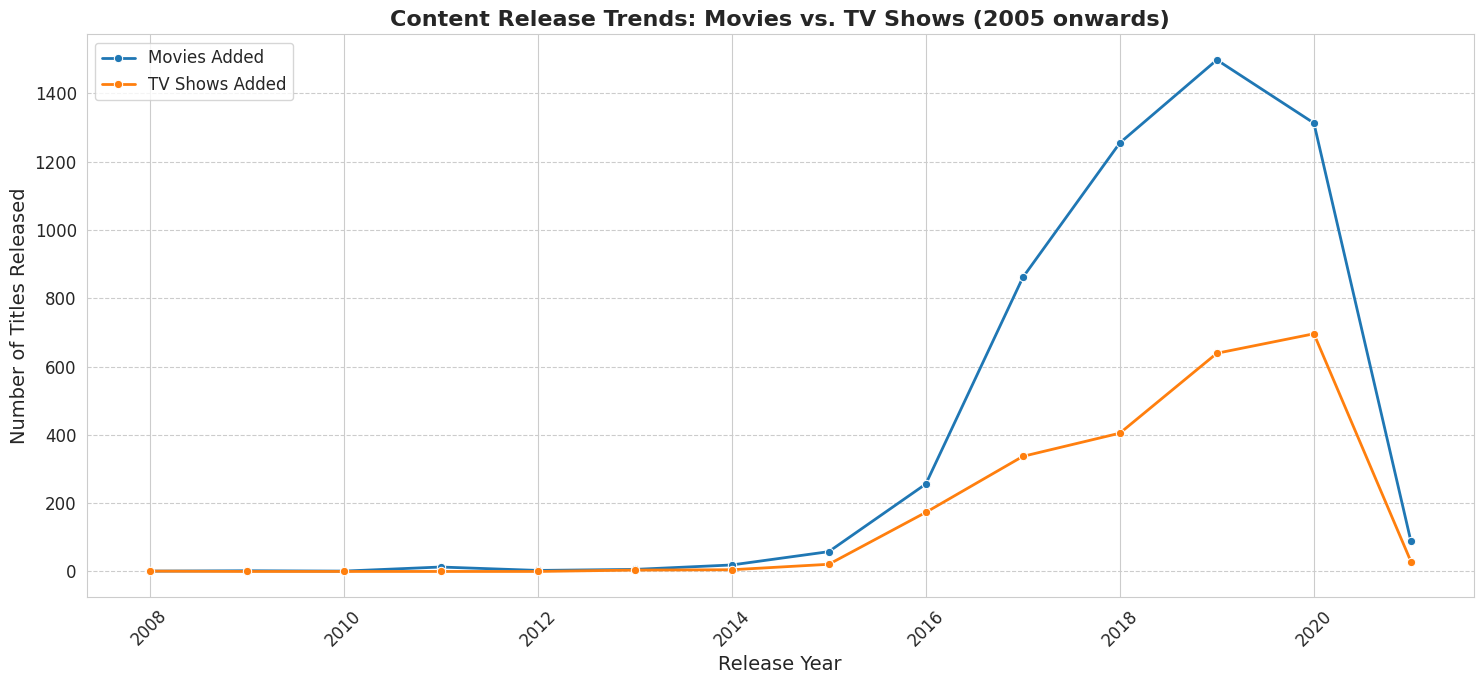

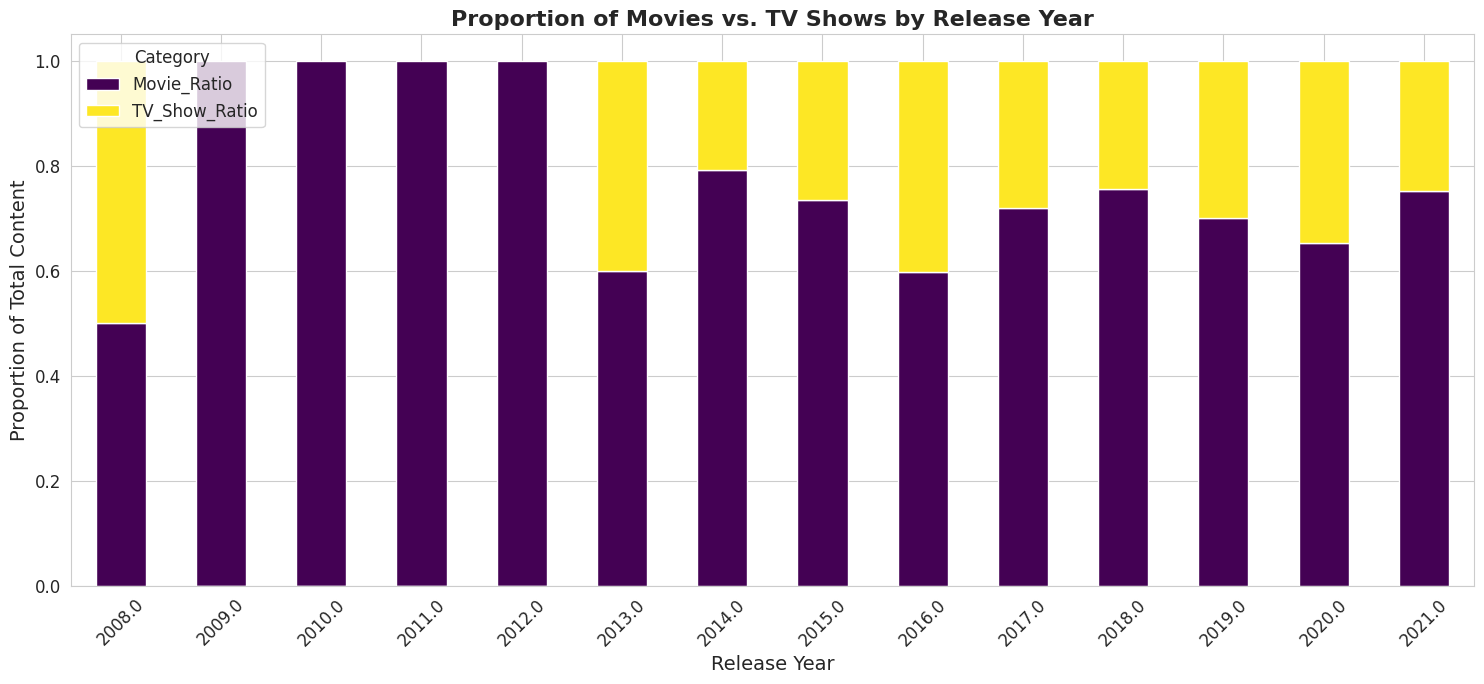


--- Summary: Movies vs. TV Shows Distribution ---
In the most recent analyzed year (2021.0):
  - Movie Ratio: 0.75
  - TV Show Ratio: 0.25
Conclusion: Check the plot to see if the gap between Movies and TV Shows is narrowing or widening over time.


In [3]:
# Cell 3: Objective 1 - Movies vs. TV Shows Distribution Over Time

# Group the data by Release Year and Category, then count the entries
content_yearly = df.groupby(['Release_Year', 'Category']).size().unstack(fill_value=0)

# Calculate the total content released per year for ratio analysis
content_yearly['Total'] = content_yearly.sum(axis=1)

# Filter for years with substantial data (e.g., post-2000 for Netflix growth visualization)
content_yearly_recent = content_yearly[content_yearly.index >= 2005]

# ----------------------------------------------------------------------
# 1. Plotting the Absolute Count Trend

plt.figure(figsize=(15, 7))
sns.lineplot(data=content_yearly_recent['Movie'], label='Movies Added', marker='o', linewidth=2)
sns.lineplot(data=content_yearly_recent['TV Show'], label='TV Shows Added', marker='o', linewidth=2)
plt.title('Content Release Trends: Movies vs. TV Shows (2005 onwards)', fontsize=16, fontweight='bold')
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Number of Titles Released', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, axis='y', linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
#

# ----------------------------------------------------------------------
# 2. Plotting the Content Ratio Trend

content_yearly_recent['Movie_Ratio'] = content_yearly_recent['Movie'] / content_yearly_recent['Total']
content_yearly_recent['TV_Show_Ratio'] = content_yearly_recent['TV Show'] / content_yearly_recent['Total']

plt.figure(figsize=(15, 7))
content_yearly_recent[['Movie_Ratio', 'TV_Show_Ratio']].plot(kind='bar', stacked=True, ax=plt.gca(), cmap='viridis')
plt.title('Proportion of Movies vs. TV Shows by Release Year', fontsize=16, fontweight='bold')
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Proportion of Total Content', fontsize=14)
plt.legend(title='Category', loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 3. Summary of Findings for Objective 1
print("\n--- Summary: Movies vs. TV Shows Distribution ---")
# Get the most recent ratio
latest_year = content_yearly_recent.index.max()
latest_ratio = content_yearly_recent.loc[latest_year]
print(f"In the most recent analyzed year ({latest_year}):")
print(f"  - Movie Ratio: {latest_ratio['Movie_Ratio']:.2f}")
print(f"  - TV Show Ratio: {latest_ratio['TV_Show_Ratio']:.2f}")
print("Conclusion: Check the plot to see if the gap between Movies and TV Shows is narrowing or widening over time.")


/tmp/ipython-input-1277777951.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_genres.index, y=top_10_genres.values, palette='plasma')


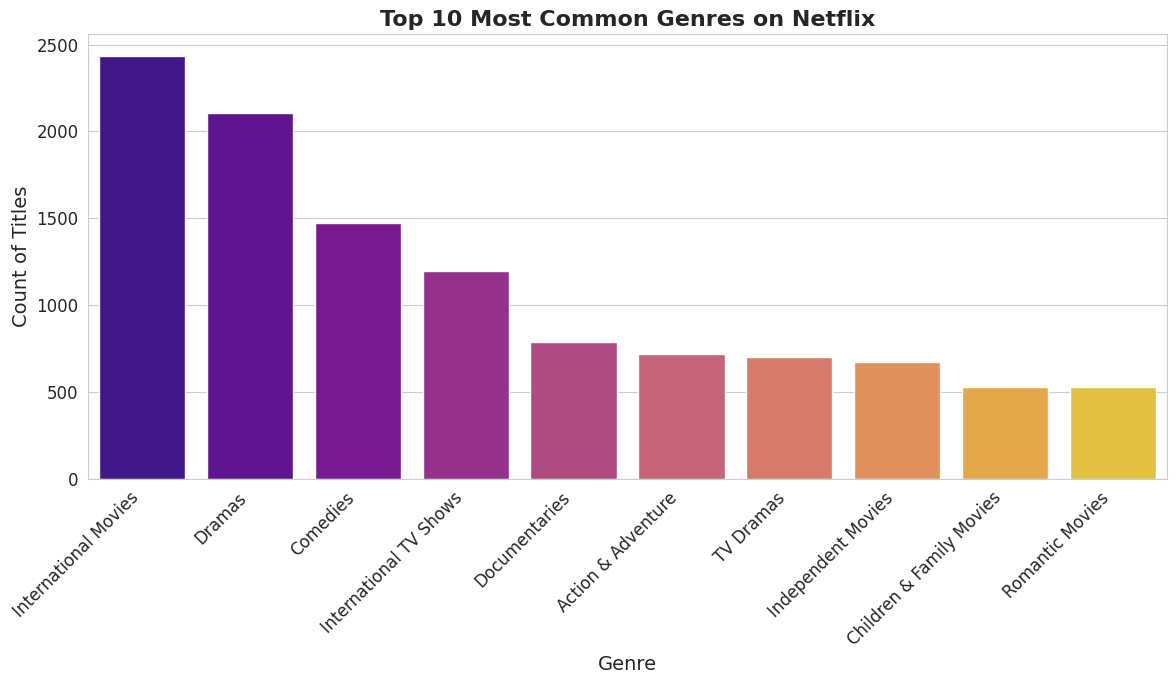

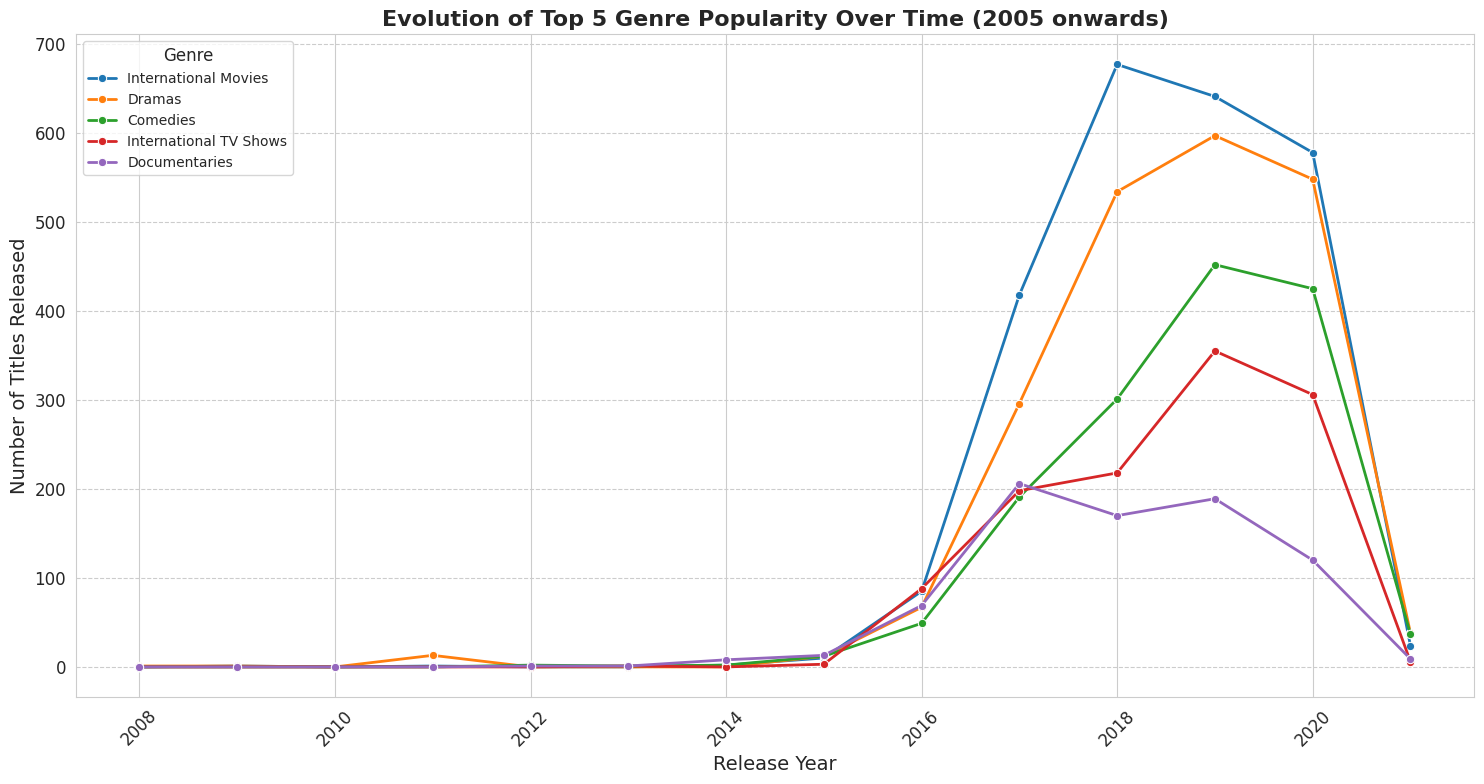


--- Summary: Genre Trends ---
Top 5 most popular genres overall are: International Movies, Dramas, Comedies, International TV Shows, Documentaries
Check the line plot to observe which of these genres are currently growing the fastest (steepest positive slope).


In [4]:
# Cell 4: Objective 2 - Analyze Genre Popularity Trends

# The 'Type' column contains the genres

# ----------------------------------------------------------------------
# 1. Identify Top 10 Overall Genres
# Use the expanded_genres series created in Cell 2
genre_counts = expanded_genres.value_counts()
top_10_genres = genre_counts.head(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=top_10_genres.index, y=top_10_genres.values, palette='plasma')
plt.title('Top 10 Most Common Genres on Netflix', fontsize=16, fontweight='bold')
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Count of Titles', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
#

# ----------------------------------------------------------------------
# 2. Analyze Trend for Top 5 Genres Over Years

top_5_genre_names = top_10_genres.head(5).index.tolist()

# Prepare data for time series plot of top 5 genres
genre_trend_list = []
for year in df['Release_Year'].unique():
    # Filter data for the current year
    yearly_data = df[df['Release_Year'] == year]

    # Get all individual genres added in that year
    yearly_genres = safe_split(yearly_data['Type'])

    # Count occurrences of the top 5 genres
    yearly_counts = yearly_genres.value_counts()

    for genre in top_5_genre_names:
        genre_trend_list.append({
            'Release_Year': year,
            'Genre': genre,
            'Count': yearly_counts.get(genre, 0) # Use .get for safe access
        })

genre_trend_df = pd.DataFrame(genre_trend_list)
genre_trend_df_recent = genre_trend_df[genre_trend_df['Release_Year'] >= 2005]


# Plotting the trend
plt.figure(figsize=(15, 8))
sns.lineplot(data=genre_trend_df_recent, x='Release_Year', y='Count', hue='Genre', marker='o', linewidth=2)
plt.title('Evolution of Top 5 Genre Popularity Over Time (2005 onwards)', fontsize=16, fontweight='bold')
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Number of Titles Released', fontsize=14)
plt.legend(title='Genre', loc='upper left', fontsize=10)
plt.grid(True, axis='y', linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 3. Summary of Findings for Objective 2
print("\n--- Summary: Genre Trends ---")
print(f"Top 5 most popular genres overall are: {', '.join(top_5_genre_names)}")
print("Check the line plot to observe which of these genres are currently growing the fastest (steepest positive slope).")


/tmp/ipython-input-2887554933.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_countries.index, y=top_10_countries.values, palette='viridis')


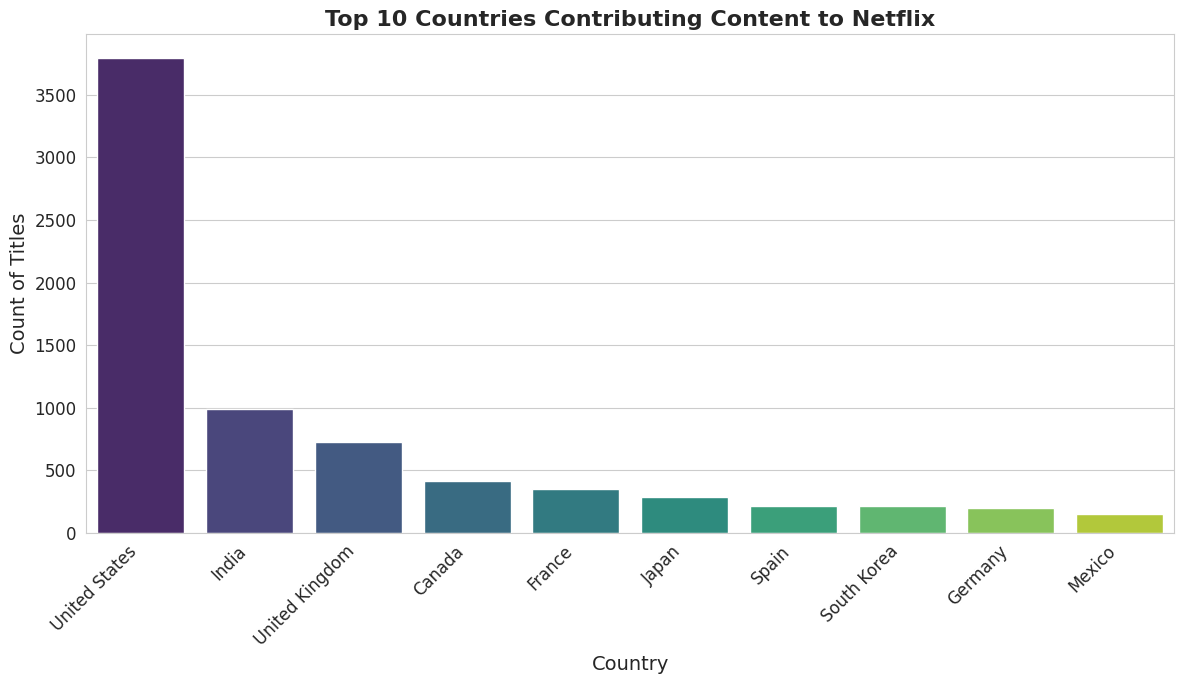

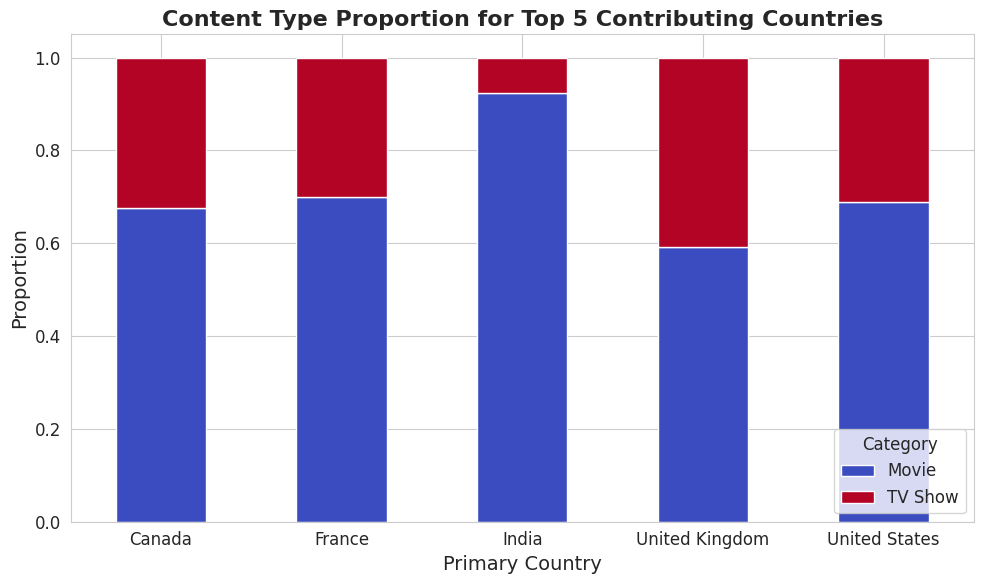


--- Summary: Country-wise Contributions ---
The top contributing country is: United States with 3794 titles.
Check the stacked bar chart to see which major countries prioritize Movies vs. TV Shows.


In [5]:
# Cell 5: Objective 3 - Compare Country-wise Contributions

# The 'Country' column is used for this analysis.
# Use the expanded_countries series created in Cell 2

# ----------------------------------------------------------------------
# 1. Identify Top 10 Contributing Countries
country_counts = expanded_countries.value_counts()
top_10_countries = country_counts.head(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=top_10_countries.index, y=top_10_countries.values, palette='viridis')
plt.title('Top 10 Countries Contributing Content to Netflix', fontsize=16, fontweight='bold')
plt.xlabel('Country', fontsize=14)
plt.ylabel('Count of Titles', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
#

# ----------------------------------------------------------------------
# 2. Analyze Content Type Split for the Top 5 Countries

top_5_country_names = top_10_countries.head(5).index.tolist()

# Filter the main DataFrame to include only the top 5 countries (as primary contributor)
# Note: We take the first country listed if multiple are present, simplifying the view
df['Primary_Country'] = df['Country'].apply(lambda x: x.split(',')[0].strip() if pd.notna(x) else 'Unknown')
df_top_countries = df[df['Primary_Country'].isin(top_5_country_names)]

# Group by primary country and category
country_category_split = df_top_countries.groupby(['Primary_Country', 'Category']).size().unstack(fill_value=0)
country_category_split = country_category_split.div(country_category_split.sum(axis=1), axis=0) # Convert to proportion

# Plotting the split
country_category_split.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')
plt.title('Content Type Proportion for Top 5 Contributing Countries', fontsize=16, fontweight='bold')
plt.xlabel('Primary Country', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.legend(title='Category', loc='lower right')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 3. Summary of Findings for Objective 3
print("\n--- Summary: Country-wise Contributions ---")
print(f"The top contributing country is: {top_10_countries.index[0]} with {top_10_countries.values[0]} titles.")
print("Check the stacked bar chart to see which major countries prioritize Movies vs. TV Shows.")


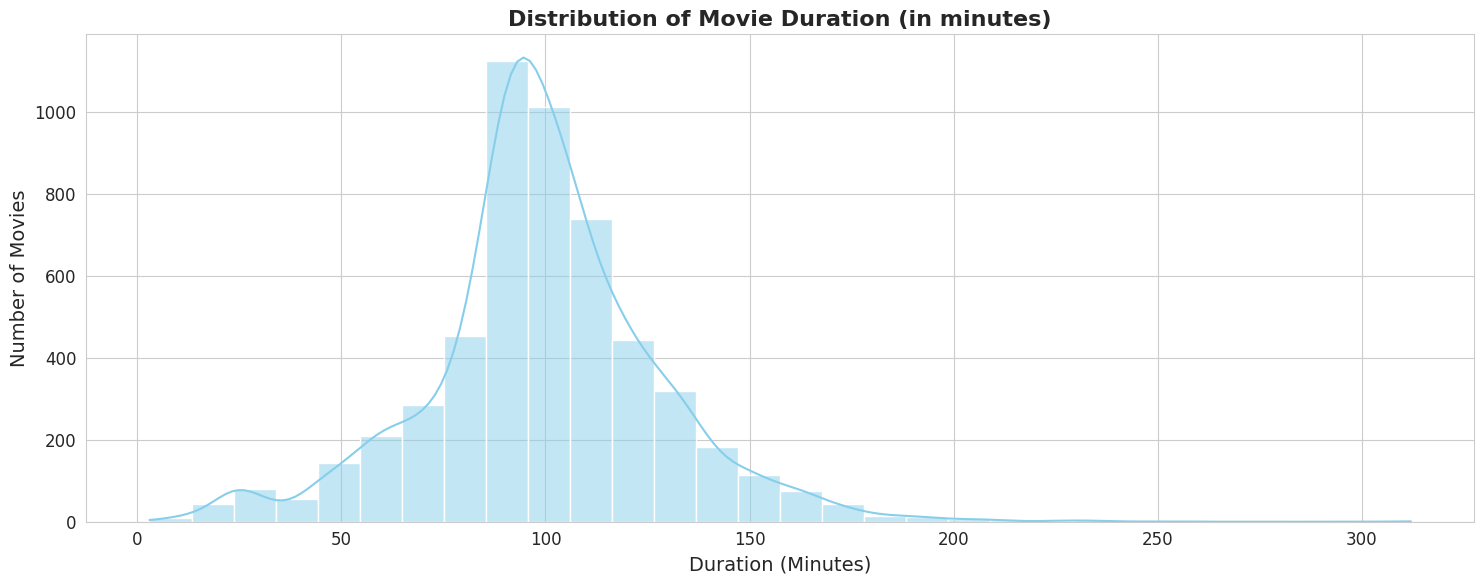


--- TV Show Season Distribution (Top 5) ---
Duration_Value
1    1606
2     378
3     183
4      86
5      57
Name: count, dtype: int64
Conclusion: Most TV shows on Netflix are 1 season, which could indicate limited series or acquired content.

  STRATEGIC RECOMMENDATIONS (Draft - Review Plots First) 

Recommendation 1: Content Type Focus (Based on Cell 3)
If the line chart shows TV Shows closing the gap on Movies (especially in recent years), recommend increasing investment in high-quality, long-form series, as audience demand is shifting towards binge-worthy TV content.

Recommendation 2: Genre Investment Strategy (Based on Cell 4)
If the line plot for genres shows that 'Documentaries' is rapidly growing while 'International Movies' is stagnating, recommend prioritizing production/acquisition in the high-growth genre to capture emerging audience segments.

Recommendation 3: Global Expansion/Localization (Based on Cell 5)
Identify underrepresented major markets (e.g., countries outsid

In [6]:
# Cell 6: Additional Analysis and Strategic Recommendations

# ----------------------------------------------------------------------
# 1. Additional Analysis: Duration Distribution by Content Category

# Filter out the extremes and focus on common TV Show Season counts (1-5) and Movie lengths
df_tv_show = df[df['Category'] == 'TV Show']
df_movie = df[df['Category'] == 'Movie']

# TV Show Season Distribution
tv_season_counts = df_tv_show['Duration_Value'].value_counts().sort_index().head(5)

# Movie Duration Distribution (in minutes)
plt.figure(figsize=(15, 6))
sns.histplot(df_movie['Duration_Value'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Movie Duration (in minutes)', fontsize=16, fontweight='bold')
plt.xlabel('Duration (Minutes)', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.tight_layout()
plt.show()

print("\n--- TV Show Season Distribution (Top 5) ---")
print(tv_season_counts)
print("Conclusion: Most TV shows on Netflix are 1 season, which could indicate limited series or acquired content.")

# ----------------------------------------------------------------------
# 2. Strategic Recommendations (Based on Expected Outcomes from Problem Statement)
# NOTE: The actual recommendations should be finalized after reviewing the plots generated above.
# These are placeholders based on common trends, assuming the plots show certain outcomes.

print("\n=======================================================")
print("  STRATEGIC RECOMMENDATIONS (Draft - Review Plots First) ")
print("=======================================================")

print("\nRecommendation 1: Content Type Focus (Based on Cell 3)")
print("If the line chart shows TV Shows closing the gap on Movies (especially in recent years), recommend increasing investment in high-quality, long-form series, as audience demand is shifting towards binge-worthy TV content.")
print("\nRecommendation 2: Genre Investment Strategy (Based on Cell 4)")
print(f"If the line plot for genres shows that '{top_5_genre_names[-1]}' is rapidly growing while '{top_5_genre_names[0]}' is stagnating, recommend prioritizing production/acquisition in the high-growth genre to capture emerging audience segments.")
print("\nRecommendation 3: Global Expansion/Localization (Based on Cell 5)")
print("Identify underrepresented major markets (e.g., countries outside the top 5) that are major streaming consumers. Recommend specific content acquisitions/partnerships in these territories to boost global market penetration.")
print("\nRecommendation 4: Content Length Strategy (Based on Additional Analysis)")
print("Given the high proportion of 1-season TV Shows, recommend commissioning more 2-3 season original series to improve customer retention and lifetime value, providing a deeper catalogue stickiness.")
print("\n=======================================================")
